In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from get_data import get_memristor_data
from get_data import normalizer
from utils import build_multilayer_network, memristor_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# TODO: initilizing the params / normalizing the data
# initializer=tf.contrib.layers.xavier_initializer()

# Clean up variable names

# You need to supply the memristor functions

# try linear encoding and decoding

# need to normalize vmin and vmax at say -1, +1
# do something similar for R min/max

In [3]:
tf.app.flags.DEFINE_integer('batch_size', 100, 'Batch Size.')
tf.app.flags.DEFINE_integer('num_iters', 1000, 'Number of iterations per epoch.')
tf.app.flags.DEFINE_integer('num_epochs', 10, 'Number of epochs.')

FLAGS = tf.app.flags.FLAGS

In [4]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
def normalizer_t(x,new_min,new_max):
    x_max = np.amax(x)
    x_min = np.amin(x)
    
    return (((x-x_min)/(x_max-x_min))*(new_max-new_min)+new_min)

In [6]:
def RV_density_plot(Vs,Rs):
    v_flat = np.ravel(Vs)
    r_flat = np.ravel((Rs))

    r_indx = np.isfinite(r_flat)

    # v_flat = np.nan_to_num(v_flat)
    v_flat = v_flat[r_indx]
    r_flat = r_flat[r_indx]

    heatmap, xedges, yedges = np.histogram2d(v_flat,r_flat, bins=300)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    plt.figure(figsize=(5,10))
    plt.imshow(heatmap.T, extent=extent, origin='lower',interpolation='nearest')
    plt.show()

In [7]:
path = '/Users/zarcone/Documents/Berkeley/Bruno_Lab/memristor/Data/Partial_Reset_PCM.pkl'
n_mem = 20
num_ext = 5
norm_min = -1.0
norm_max = 1.0
vs_data, mus_data, sigs_data, orig_VMIN, orig_VMAX, orig_RMIN, orig_RMAX = get_memristor_data(path,n_mem,num_ext,norm_min,norm_max)

n_samp, n_m = vs_data.shape

In [8]:
print (vs_data.shape, mus_data.shape,sigs_data.shape)

(50, 20) (50, 20) (50, 20)


In [9]:
vmin = tf.Variable(np.array(norm_min).astype('float32'), trainable=False, name='VMIN')
vmax = tf.Variable(np.array(norm_max).astype('float32'), trainable=False, name='VMAX')

In [10]:
d_in = 784 
n_layers = 3 
f = lambda x: x  # Nonlinearity
f = tf.nn.tanh

interp_width = np.array(vs_data[1, 0] - vs_data[0, 0]).astype('float32')
GAMMA = 1.0  # slope of the out of bounds cost

in_shape = (None, d_in)
noise_shape = (None, n_m)

n_h_e = 200 
n_h_d = 200 

learning_rate = 0.001

In [11]:
# Input
x = tf.placeholder(tf.float32, shape=in_shape)

# Noise
eps = tf.placeholder(tf.float32, shape=noise_shape)

# Values for memristors
vs = tf.Variable(initial_value=vs_data.astype('float32'), trainable=False, name='vs')
mus = tf.Variable(initial_value=mus_data.astype('float32'), trainable=False, name='mus')
sigs = tf.Variable(initial_value=sigs_data.astype('float32'), trainable=False, name='sigs')

In [12]:
def tensor_scaler(x,new_min,new_max):
    x_max = tf.reduce_max(x)
    x_min = tf.reduce_min(x)
    
    return (((x-x_min)/(x_max-x_min))*(new_max-new_min)+new_min)

In [13]:
with tf.variable_scope('encoder'):
    v = build_multilayer_network(x, [d_in, n_h_e, n_m], f=f)
    v_clip = tf.clip_by_value(v, vmin, vmax)
    v_trans = tensor_scaler(v_clip,orig_VMIN,orig_VMAX)

In [14]:
with tf.variable_scope('memristor'):
    r = memristor_output(v_clip, eps, vs, mus, sigs, interp_width=interp_width)
    r_trans =  tensor_scaler(r, orig_RMIN, orig_RMAX)

with tf.variable_scope('decoder'):
    xh = build_multilayer_network(r, [n_m, n_h_d, d_in])

In [15]:
# Penalty for going out of bounds
gamma = tf.Variable(np.array(GAMMA).astype('float32'), trainable=False, name='GAMMA')
reg_cost = tf.reduce_sum(gamma * (tf.nn.relu(v - vmax) + tf.nn.relu(vmin - v))) # CHECK ME

In [16]:
def SNR_calc(x,xh):
    return tf.reduce_mean(tf.reduce_sum(x**2,1)/tf.reduce_sum((x-xh)**2,1))

In [17]:
rec_cost = tf.nn.l2_loss(x - xh)  # Reconstruction cost

SNR = SNR_calc(x,xh)

cost = rec_cost + reg_cost

In [18]:
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [19]:
#Creating Saver to save and restore variables 
saver = tf.train.Saver()

In [20]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
config = tf.ConfigProto(gpu_options=gpu_options)

with tf.Session(config=config) as sess:
    sess.run(tf.initialize_all_variables())
    for j in range(FLAGS.num_epochs):
        for i in range(FLAGS.num_iters):
            batch = mnist.train.next_batch(FLAGS.batch_size)
            eps_values = np.random.randn(batch[0].shape[0],n_m) 
            sess.run(train_step, 
                     feed_dict={x: batch[0], eps: eps_values})
        eps_eval_values = np.random.randn(mnist.test.images.shape[0],n_m) 
        out = sess.run([cost, rec_cost,reg_cost,SNR],feed_dict={x: mnist.test.images, eps: eps_eval_values})
        cost_val, rec_cost_val, reg_cost_val, SNR_val = out
        
        print ('cost: ', cost_val, 'rec_cost: ',rec_cost_val,'reg_cost',reg_cost_val, 'SNR: ', SNR_val)
    save_path = saver.save(sess, "/tmp/model.ckpt")
    print("Model saved in file: %s" % save_path)

cost:  149930.0 rec_cost:  149930.0 reg_cost 0.0 SNR:  3.08063
cost:  137908.0 rec_cost:  137908.0 reg_cost 0.0 SNR:  3.3791
cost:  128494.0 rec_cost:  128494.0 reg_cost 0.0 SNR:  3.67844
cost:  119189.0 rec_cost:  119189.0 reg_cost 0.0 SNR:  4.01497
cost:  111540.0 rec_cost:  111540.0 reg_cost 0.0 SNR:  4.34591
cost:  107927.0 rec_cost:  107927.0 reg_cost 0.0 SNR:  4.50689
cost:  104801.0 rec_cost:  104801.0 reg_cost 0.0 SNR:  4.67015
cost:  102505.0 rec_cost:  102505.0 reg_cost 0.0 SNR:  4.79785
cost:  100579.0 rec_cost:  100579.0 reg_cost 0.0 SNR:  4.90568
cost:  99258.4 rec_cost:  99258.4 reg_cost 0.0 SNR:  4.97366
Model saved in file: /tmp/model.ckpt


# Inspecting variables:

In [31]:
with tf.Session(config=config) as sess:
    saver.restore(sess, "/tmp/model.ckpt")
    print("Model restored!")
    eps_eval_values = np.random.randn(mnist.test.images.shape[0],n_m) 
    out = sess.run([x,xh,v,v_clip,v_trans,r_trans],feed_dict={x: mnist.test.images, eps: eps_eval_values})
    x_val,xh_val,v_val,v_clip_val,v_trans_val,r_trans_val = out
    

Model restored!


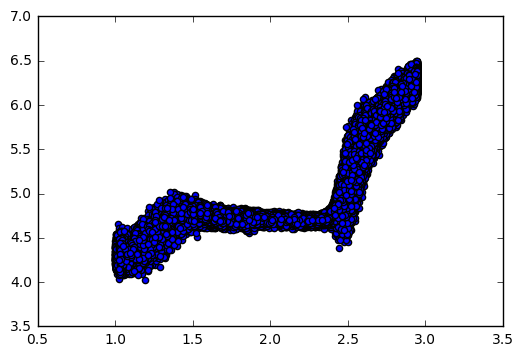

In [32]:
plt.scatter(v_trans_val,r_trans_val)

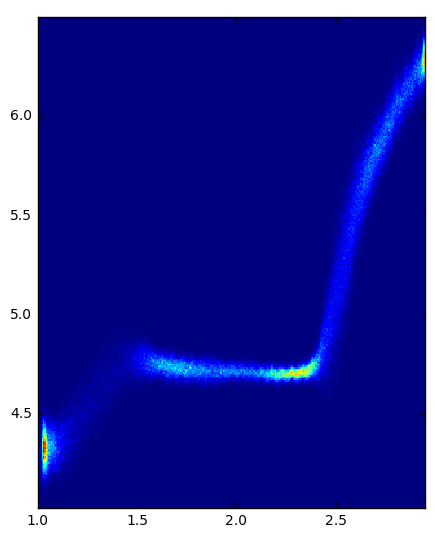

In [33]:
RV_density_plot(v_trans_val,r_trans_val)

In [34]:
test_im = xh_val[0].reshape(28,28)
print (test_im.shape)

(28, 28)


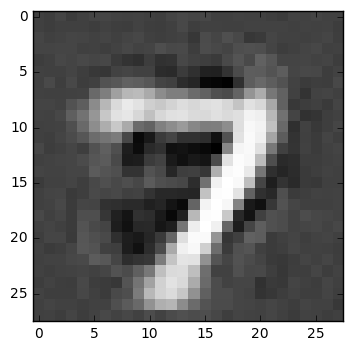

In [35]:
plt.figure()
plt.imshow(test_im, cmap='Greys_r',interpolation='nearest')

In [36]:
def plot_digit(ax,x_i,dim=28):
    test_im = x_i.reshape(dim,dim)
    ax.imshow(test_im, cmap='Greys_r',interpolation='nearest')

def plot_digits(xh,x,plot_grid):
    num_imgs = plot_grid[0]*plot_grid[1]
    
    fig, axes = plt.subplots(plot_grid[0], 2*plot_grid[1],figsize=(15,10))
    i=0
    for row in axes:
        count = 0
        for ax in row:
            if count%2 == 0:
                plot_digit(ax,xh[i],28)
                i+=1
            else: 
                plot_digit(ax,x[i],28)
            count+=1
    plt.tight_layout()

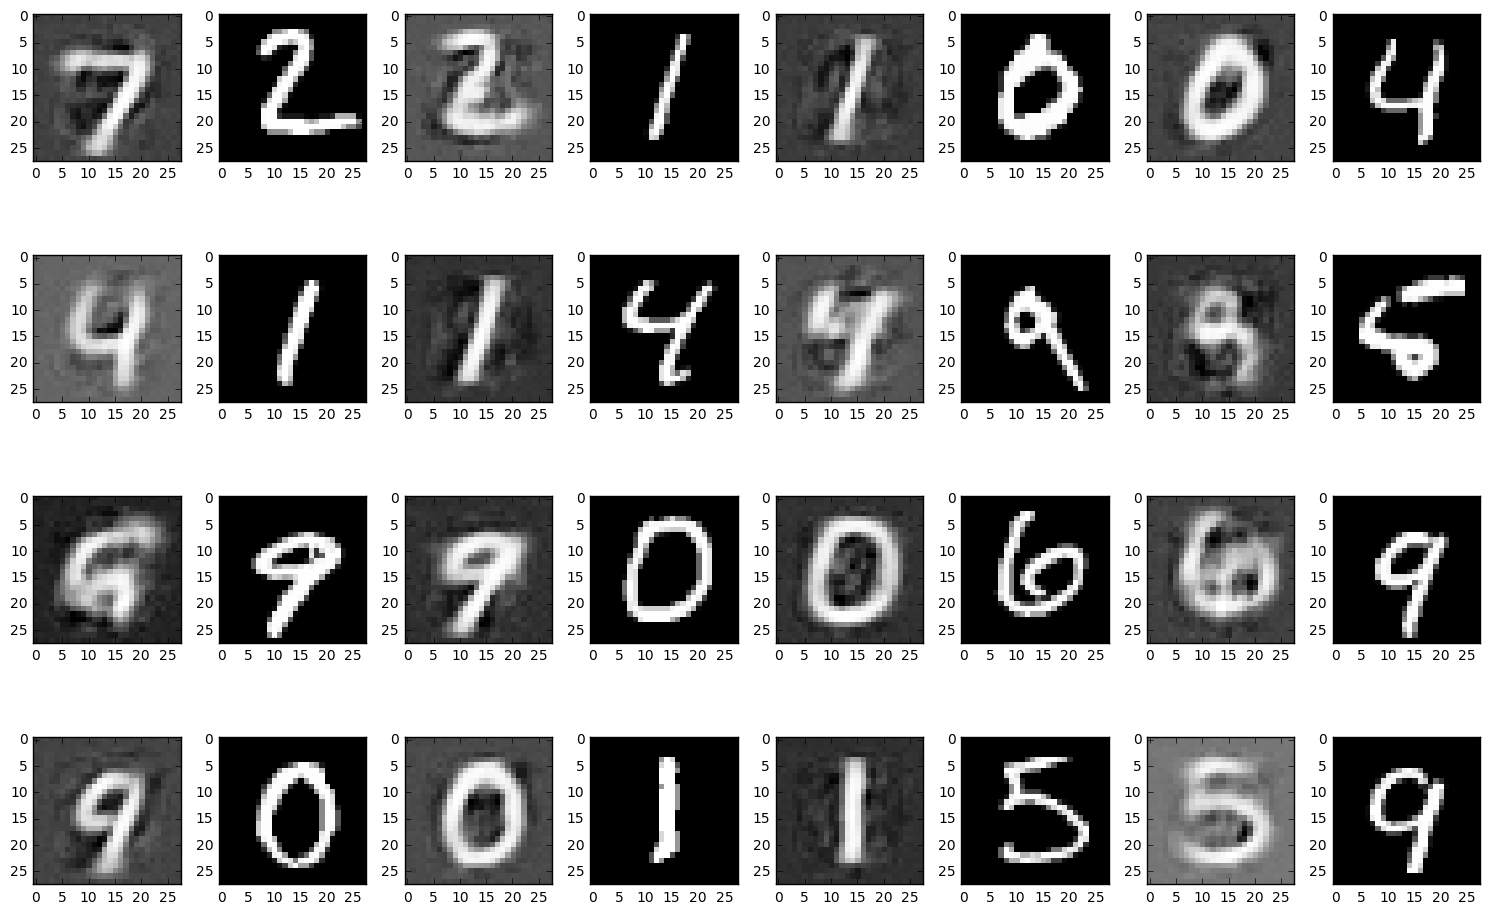

In [38]:
plot_grid = [4,4]
plot_digits(xh_val,x_val,plot_grid)